## Фаза1. Неделя 1. Среда


### A/B - тесты

In [60]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [61]:
transactions = pd.read_csv("data/transactions.csv").drop("Unnamed: 0", axis=1)
users = pd.read_csv("data/users.csv").drop("Unnamed: 0", axis=1)

In [62]:
transactions.head()

,transaction_id,user_id,date,revenue,group
0,6776893763,3392612285,2017-06-15,3758.2,B
1,40289040,8006342366,2017-06-15,1518.7,B
2,1256395556,966904442,2017-06-15,778.4,A
3,4376547739,9761119562,2017-06-15,27081.5,B
4,2237026988,8938272722,2017-06-15,5456.7,B


In [63]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  1197 non-null   int64  
 1   user_id         1197 non-null   int64  
 2   date            1197 non-null   object 
 3   revenue         1197 non-null   float64
 4   group           1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [64]:
users.head()

,date,group,count_users
0,2017-06-01,A,1016.0
1,2017-06-02,A,868.0
2,2017-06-03,A,704.0
3,2017-06-04,A,1013.0
4,2017-06-05,A,1072.0


In [65]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  1197 non-null   int64  
 1   user_id         1197 non-null   int64  
 2   date            1197 non-null   object 
 3   revenue         1197 non-null   float64
 4   group           1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


1. Постройте график кумулятивной выручки по группам. Опишите выводы

In [66]:
transactions["date"] = pd.to_datetime(transactions["date"])

In [67]:
daily_rev = (
    transactions.groupby(["date", "group"], as_index=False)["revenue"]
    .sum()
    .rename(columns={"revenue": "daily_revenue"})
)

In [68]:
daily_rev["cum_revenue"] = (
    daily_rev.sort_values(["group", "date"]).groupby("group")["daily_revenue"].cumsum()
)

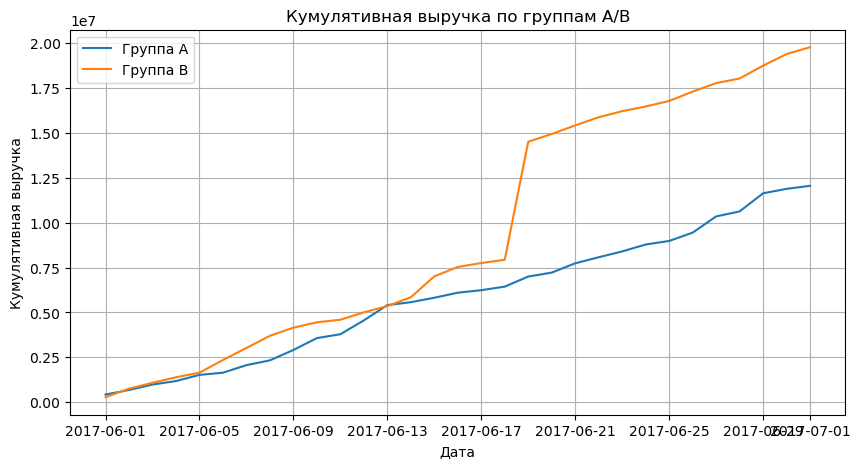

In [69]:
plt.figure(figsize=(10, 5))
for group in daily_rev["group"].unique():
    group_data = daily_rev[daily_rev["group"] == group]
    plt.plot(group_data["date"], group_data["cum_revenue"], label=f"Группа {group}")

plt.title("Кумулятивная выручка по группам A/B")
plt.xlabel("Дата")
plt.ylabel("Кумулятивная выручка")
plt.grid()
plt.legend()
plt.show()

Группа B показывает лучший результат по кумулятивной выручке

2. Постройте график кумулятивного среднего чека по группам. Опишите выводы

In [70]:
daily_rev.head()

,date,group,daily_revenue,cum_revenue
0,2017-06-01,A,420253.3,420253.3
1,2017-06-01,B,271805.0,271805.0
2,2017-06-02,A,255111.9,675365.2
3,2017-06-02,B,477378.1,749183.1
4,2017-06-03,A,302952.4,978317.6


In [71]:
daily_orders = (
    transactions.groupby(["date", "group"]).size().reset_index(name="daily_orders")
)


daily_orders = daily_orders.sort_values(["group", "date"]).assign(
    cum_orders=lambda d: d.groupby("group")["daily_orders"].cumsum()
)


daily = (
    daily_rev[["date", "group", "cum_revenue"]]
    .merge(
        daily_orders[["date", "group", "cum_orders"]], on=["date", "group"], how="inner"
    )
    .sort_values(["group", "date"])
)


daily["cum_avg_check"] = daily["cum_revenue"] / daily["cum_orders"].replace(0, pd.NA)

In [72]:
daily.head()

,date,group,cum_revenue,cum_orders,cum_avg_check
0,2017-06-01,A,420253.3,24,17510.554167
2,2017-06-02,A,675365.2,44,15349.209091
4,2017-06-03,A,978317.6,68,14387.023529
6,2017-06-04,A,1171752.4,84,13949.433333
8,2017-06-05,A,1516585.9,109,13913.632110


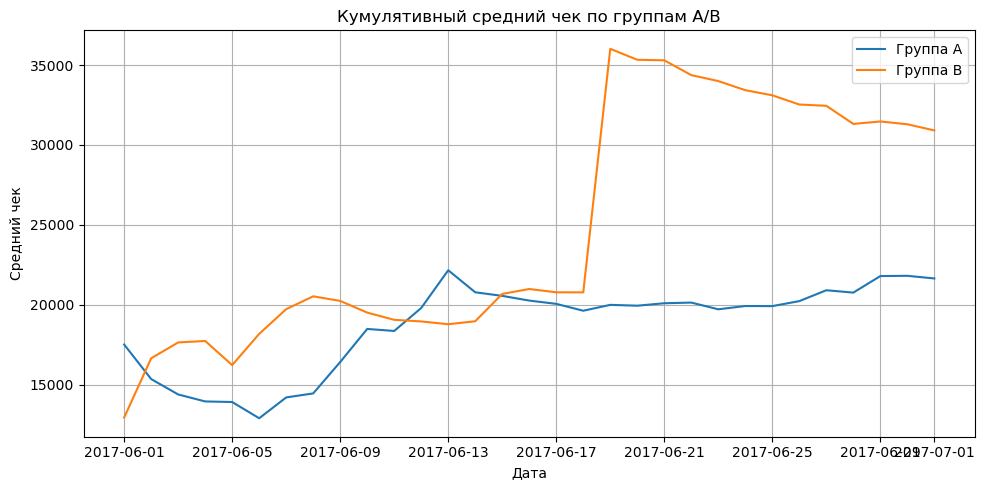

In [81]:
plt.figure(figsize=(10, 5))
for g in sorted(daily["group"].unique()):
    gd = daily[daily["group"] == g].dropna(subset=["cum_avg_check"])
    plt.plot(gd["date"], gd["cum_avg_check"], label=f"Группа {g}")

plt.title("Кумулятивный средний чек по группам A/B")
plt.xlabel("Дата")
plt.ylabel("Средний чек")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [74]:
summary = (
    daily.sort_values("date")
    .groupby("group", as_index=False)
    .tail(1)[["group", "cum_revenue", "cum_orders", "cum_avg_check"]]
    .reset_index(drop=True)
)
summary

,group,cum_revenue,cum_orders,cum_avg_check
0,A,12056583.8,557,21645.572352
1,B,19782257.0,640,30909.776562


Разрыв в кумулятивном среднем чеке формируется в основном из-за скачка в районе 19.06.2017, скорее всего из-за нескольких крупных покупок.

In [75]:
base_stats = (
    transactions.groupby("group")["revenue"]
    .agg(count="count", median="median", mean="mean", min="min", max="max")
    .round(2)
)
base_stats

,count,median,mean,min,max
group,,,,,
A,557,7302.4,21645.57,77.2,335266.0
B,640,7207.8,30909.78,77.2,6183359.6


Медианы чеков почти равные, а вот максимальные значения отличаются на порядок. Значит разница в среднем формируется из-за крупных выбросов в группе B

3. График относительного изменения кумулятивного среднего чека группы B к группе A. Опишите выводы

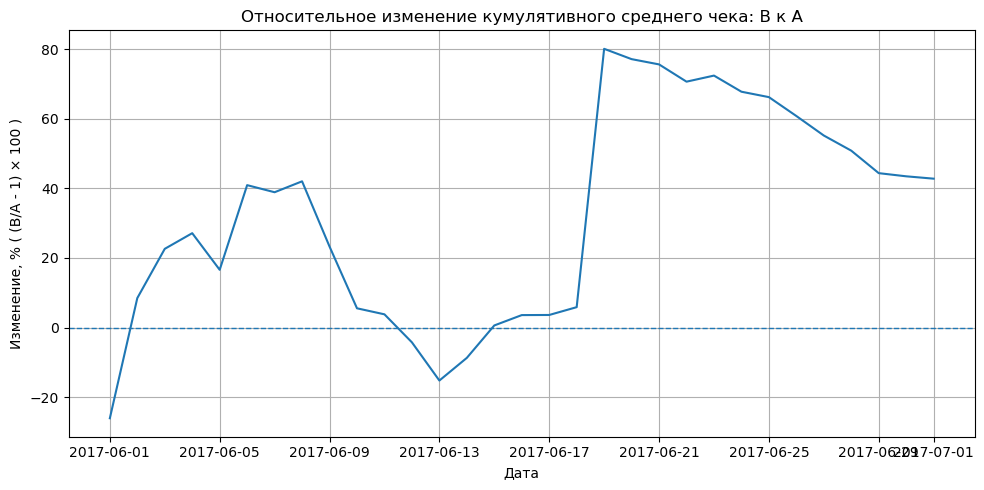

Финал: 42.80% на 2017-07-01
Максимум: 80.14% на 2017-06-19
Минимум: -26.08% на 2017-06-01


In [76]:
pivot_avg = daily.pivot(index="date", columns="group", values="cum_avg_check")


rel = pivot_avg["B"] / pivot_avg["A"] - 1
rel_pct = rel * 100


plt.figure(figsize=(10, 5))
plt.plot(rel_pct.index, rel_pct.values)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Относительное изменение кумулятивного среднего чека: B к A")
plt.xlabel("Дата")
plt.ylabel("Изменение, % ( (B/A - 1) × 100 )")
plt.tight_layout()
plt.grid()
plt.show()


final_val = rel_pct.iloc[-1]
peak_date, peak_val = rel_pct.idxmax(), rel_pct.max()
low_date, low_val = rel_pct.idxmin(), rel_pct.min()
print(
    f'Финал: {final_val:.2f}% на {final_val.index[-1] if hasattr(final_val,"index") else rel_pct.index[-1].date()}'
)
print(f"Максимум: {peak_val:.2f}% на {peak_date.date()}")
print(f"Минимум: {low_val:.2f}% на {low_date.date()}")

4. График кумулятивного среднего количества заказов по группам. 

In [77]:
users_cum = (
    users.assign(date=pd.to_datetime(users["date"]))
    .sort_values(["group", "date"])
    .assign(cum_users=lambda d: d.groupby("group")["count_users"].cumsum())[
        ["date", "group", "cum_users"]
    ]
)

orders_users = (
    daily[["date", "group", "cum_orders"]]
    .merge(users_cum, on=["date", "group"], how="inner")
    .sort_values(["group", "date"])
)

orders_users["cum_avg_orders"] = orders_users["cum_orders"] / orders_users["cum_users"]

In [78]:
users_cum.head()

,date,group,cum_users
0,2017-06-01,A,1016.0
1,2017-06-02,A,1884.0
2,2017-06-03,A,2588.0
3,2017-06-04,A,3601.0
4,2017-06-05,A,4673.0


In [79]:
orders_users.head()

,date,group,cum_orders,cum_users,cum_avg_orders
0,2017-06-01,A,24,1016.0,0.023622
1,2017-06-02,A,44,1884.0,0.023355
2,2017-06-03,A,68,2588.0,0.026275
3,2017-06-04,A,84,3601.0,0.023327
4,2017-06-05,A,109,4673.0,0.023325


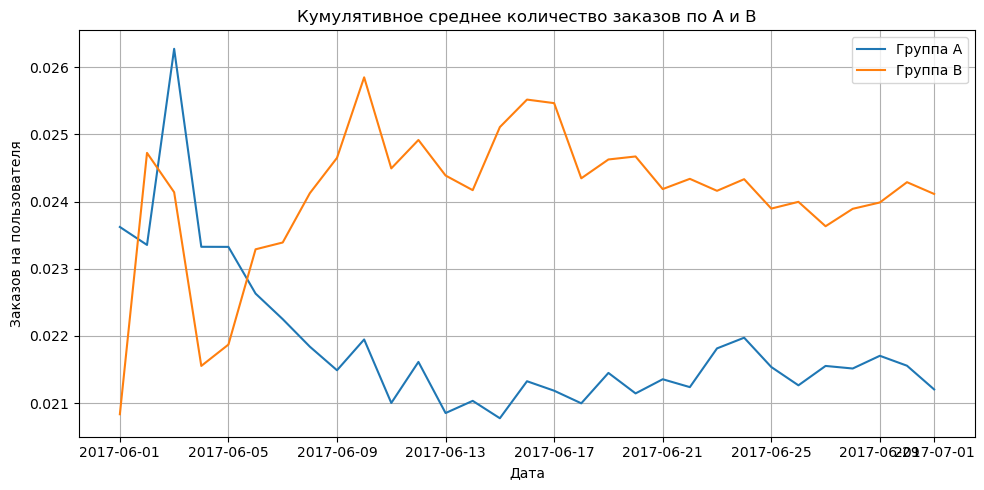

In [80]:
plt.figure(figsize=(10,5))
for g in sorted(orders_users['group'].unique()):
    gd = orders_users[orders_users['group'] == g]
    plt.plot(gd['date'], gd['cum_avg_orders'], label=f'Группа {g}')
plt.title('Кумулятивное среднее количество заказов по A и B')
plt.xlabel('Дата')
plt.ylabel('Заказов на пользователя')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

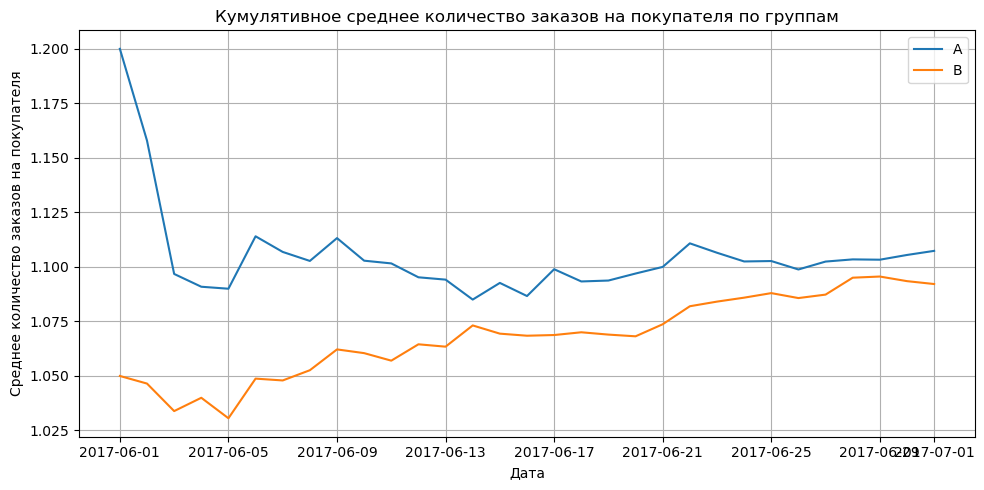

In [ ]:

first_buy = (
    transactions.groupby(['group', 'user_id'])['date'].min().reset_index(name='first_date')
)


new_buyers = (
    first_buy.groupby(['group', 'first_date']).size().reset_index(name='new_buyers')
             .rename(columns={'first_date': 'date'})
             .sort_values(['group', 'date'])
)
cum_buyers = (
    new_buyers.assign(cum_buyers=lambda d: d.groupby('group')['new_buyers'].cumsum())
              [['date', 'group', 'cum_buyers']]
)


buyers_orders = (
    daily[['date','group','cum_orders']]
    .merge(cum_buyers, on=['date','group'], how='inner')
    .sort_values(['group','date'])
)
buyers_orders['cum_avg_orders_per_buyer'] = buyers_orders['cum_orders'] / buyers_orders['cum_buyers']


plt.figure(figsize=(10,5))
for g in sorted(buyers_orders['group'].unique()):
    gd = buyers_orders[buyers_orders['group'] == g]
    plt.plot(gd['date'], gd['cum_avg_orders_per_buyer'], label=g)
plt.title('Кумулятивное среднее количество заказов на покупателя по группам')
plt.xlabel('Дата'); plt.ylabel('Среднее количество заказов на покупателя')
plt.legend(); plt.grid(); plt.tight_layout(); plt.show()


## Не правильно?

5. График относительного изменения кумулятивного среднего количества заказов группы B к группе A

6. Распределение количества заказов по пользователям.  Опишите выводы

7. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

8. Постройте распределение стоимостей заказов. Сделайте выводы и предположения.

9. Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

10. Посчитайте статистическую значимость различий в среднем количестве заказов между группами по «сырым» данным. Сделайте выводы и предположения.

11. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

12. Посчитайте статистическую значимость различий в среднем количестве заказов между группами по «очищенным» данным. Сделайте выводы и предположения.

13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

14. Примите решение по результатам теста и объясните его. Варианты решений:   
*  Остановить тест, зафиксировать победу одной из групп.  
*  Остановить тест, зафиксировать отсутствие различий между группами. 